# Pronósticos, Round 2 - Parte 4: Grey Kite

## 1. Introducción

¡Ah! ¡Los pronósticos! Uno de los grandes retos de la economía, la econometría y la estadística... de hecho, también del clima. Se trabajan mucho y en el momento en que salen al mundo están mal, puesto que es imposible adivinar el futuro. No obstante, hay quién señala que se le paga a los economistas por el esfuerzo invertido en generarlos y en justificar porque resultaron equivocados. 

Una herramienta para hacer pronósticos que me mucho gusto fue [*Prophet*](https://facebook.github.io/prophet/), cuyas implementaciones pueden ver [aquí para el anterior round](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/) y [aquí para este nuevo round](https://gonzalezhomar.netlify.app/post/pronr2_3_prophet/). Al parecer esta herramienta ha tenido un fuerte impacto en el mundo de la ciencia de datos como puede verse [aquí](), [aquí]() y [aquí](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274) donde incluso se convierte en la primer herramienta a utilizar, dejando de lado el resto (Abraham Zeperras).

En respuesta a esta herramienta desarrollada por Facebook, el equipo de inteligencia artificial de LinkedIn desarrollo el algoritmo *Silverkite* y un paquete de Python para implementarlo llamado [*Greykite*](https://linkedin.github.io/greykite/docs/0.1.0/html/pages/greykite/overview.html), con el cual planena competir con Prophet. Así que inspirado por [esta publicación](https://towardsdatascience.com/linkedins-response-to-prophet-silverkite-and-greykite-4fd0131f64cb) y por [esta otra](https://medium.com/geekculture/greykite-the-new-forecasting-library-from-linkedin-case-bitcoin-price-prediction-981d21e79b31), decidí hacer mi propia implementación. 

## 2. *Silverkite*

Al igual que *Prophet*, el algoritmo de *Silver-Kite* fue desarrollado para trabajar bien con series de tiempo, pues  su objetivo es trabajar a escala (múltiples series), puesto que de acuerdo [al paper de *Silverkite*](https://www.arxiv-vanity.com/papers/2105.01098/) tenía los siguientes objetivos:
- Flexibilidad: El modelo debe ser capaz de manejar series de tiempo con tendencia, estacionalidad, días feriados, quiebres, autoregresión, etcetera. Por lo tanto, se le permite al usuario seleccionar cuales de los componentes necesitan y ajustar el modelo seleccionado. No obstante, el modelo trae valores predeterminados que permiten usar *Silverkite* directamente.
- Interpretabildiad: Para *Silverkite* o solo importa el desempeño, sino que también importa su explicabilidad. Para ello, incluye graficas y plantillas para mejorar y explicar los pronósticos con supuestos claros.
- Velocidad: *Silverkite* permite usar plantillas para obtener pronósticos de manera rapida, por lo que sus pronósticos pueden ser implementados a escala rápidamente.

A diferencia de *Prophet*, en *Silverkite* no hay una ecuación que represente el modelo predictivo. En su lugar, presentan un diagrama con los procesos que hace el algoritmo:
- En un primer paso, extrae características que puedan influir en el modelo, como días feriados, tendencia estacionalidad.
- En segundo lugar, pasa dichas características a una base apropiada (como series de Fourier que también usa *Prophet*), para un modelo aditivo.
- En tercer lugar, *Silverkite* busca quiebres en la tendencia o en la estacionalidad. 
- De las características extraidas en el segundo y tercer paso, busca un modelo de aprendizaje automático para explicar dichas variables.
- Y finalmente, de los residuales que quedan, busca un modelo de varianza condicional para capturar la volatilidad que quede.

Al igual que en *Prophet*, el usuario, osea yo, puedo incluir variables explicativas o modificar los días feriados. Sin más explicación, veamos como funciona.

La publicación completa la dejaré [aquí](https://gonzalezhomar.netlify.app/post/pronr2_4_greykite/)

In [1]:
from fbprophet import Prophet
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import plotly
#import plotly.offline as py
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam

## 3. Análisis de las Series Mensuales

Solo dejaré comentarios para la serie de IEPS Bebidas. El resto de las series mensuales no tienen comentarios.

### 3.1 IEPS Bebidas

Para utilizar Greykite en las series mensuales, solo tengo que crear los meta parametros que le serviran a Greykite para identificar el formato de la serie: columna con la variable temporal, la variable a explicar, su frecuencia e incluso el formato de la fecha. 

Además modifiqué la estacionalidad para no considerar del tipo diaria y semanal, puesto que mis datos son mensuales. Sin embargo, los pronósticos que obtuve con esta herramienta, no me gustaron del todo. Pensé que tenía algo que ver con el índice o con las fechas, pero luego de leer otras fuentes, veo que los pronósticos de Greykite son [poco vólatiles](https://www.kaggle.com/kaustubh93/time-series-forecasting-of-dogecoin-using-greykite).

In [2]:
metadata = MetadataParam(
    time_col="ts",
    value_col="y",
    freq="MS",
    date_format='YYYY-MM-DD'
)
custom_model_components = ModelComponentsParam(
     seasonality={
         "yearly_seasonality": "auto",
         "quarterly_seasonality": "auto",
         "monthly_seasonality": "auto",
         "weekly_seasonality": False,
         "daily_seasonality": False
     }
 )

In [3]:
df = pd.read_csv('202107mensuales.csv', sep=',', parse_dates=['fecha'], encoding = 'utf-8') #, index_col='fecha'
df.reset_index
df.head()

fecha   ano  mes  dia  fechas  ieps_gas  ieps_tabacos  ieps_bebidas  \
0 2002-01-01  2002    1    1  ene-02       NaN         822.6         599.9   
1 2002-02-01  2002    2    1  feb-02       NaN         989.7         450.2   
2 2002-03-01  2002    3    1  mar-02       NaN         724.4         286.4   
3 2002-04-01  2002    4    1  abr-02       NaN         839.5         161.4   
4 2002-05-01  2002    5    1  may-02       NaN         453.1          99.4   

   ieps_cervezas  ieps_bebidassab  ieps_alimentos  importacion  rfp_petroleros  
0          785.9              NaN             NaN       2482.0          8514.1  
1         1152.3              NaN             NaN       1916.8          5589.7  
2          540.0              NaN             NaN       1803.0          3231.0  
3          702.0              NaN             NaN       1797.7          4342.8  
4          826.0              NaN             NaN       2253.6          6000.0

In [4]:
iepsb=df[['fecha','ieps_bebidas']]
iepsb=iepsb.dropna()
iepsb.columns=['ts','y']
iepsb.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [5]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepsb,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


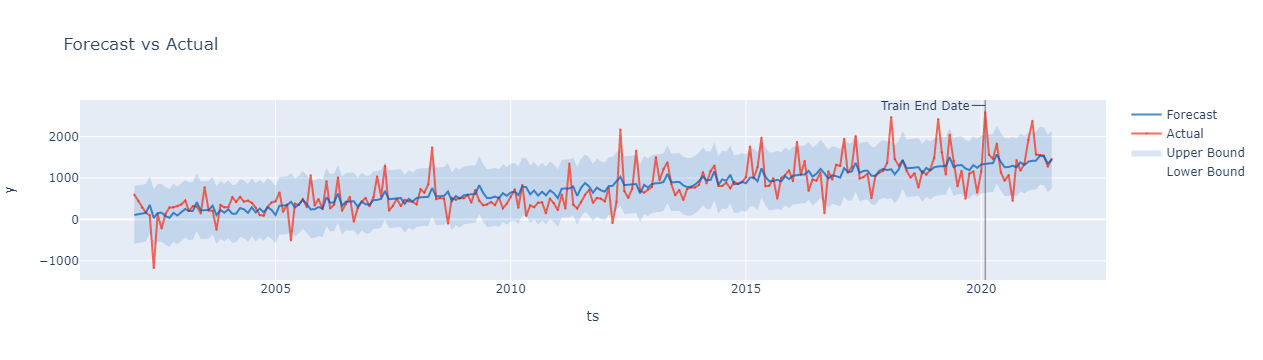

In [6]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [7]:
fig.write_html('gk_iepsb_back.html')

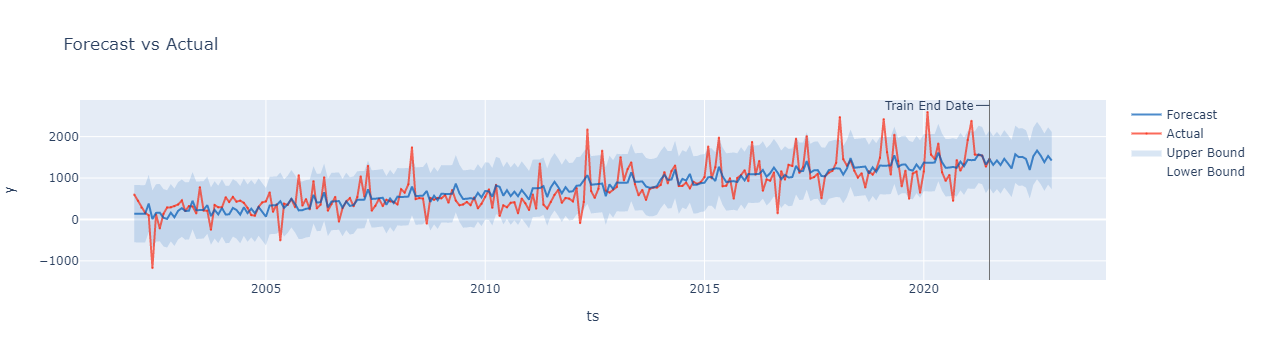

In [8]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [9]:
fig.write_html('gk_iepsb_fore.html')

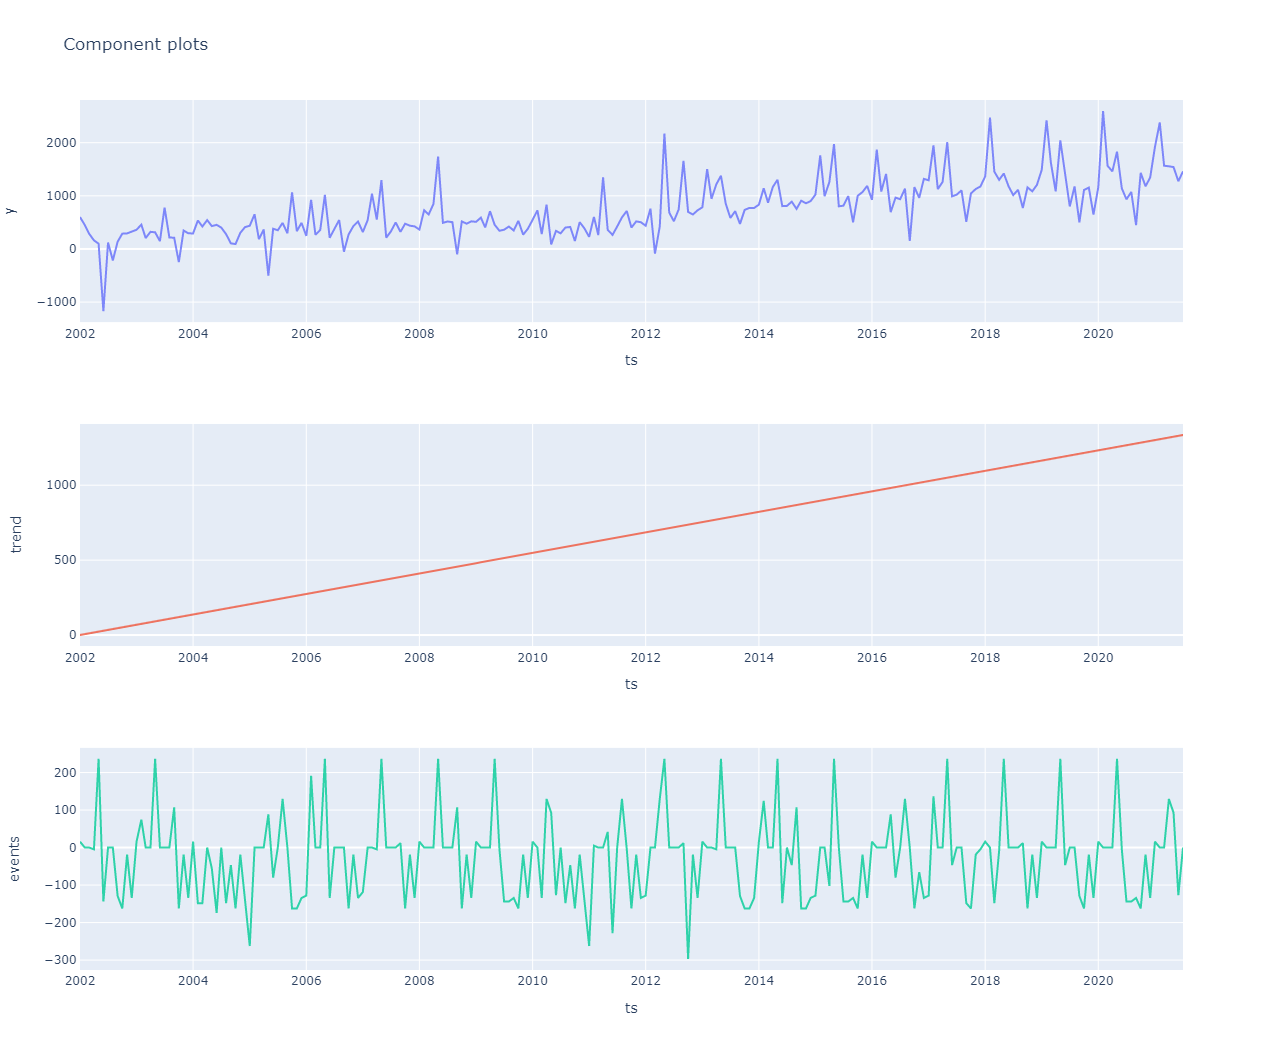

In [10]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [11]:
fig.write_html('gk_iepsb_comp.html')

In [12]:
iepsb_r=forecast.df.forecast
iepsb_r.tail()

247    1663.589226
248    1539.732115
249    1382.965740
250    1532.674383
251    1422.371195
Name: forecast, dtype: float64

### 3.2 IEPS Cervezas

In [13]:
iepsc=df[['fecha','ieps_cervezas']]
iepsc['fecha'] = iepsc['fecha'].astype('datetime64[ns]')
iepsc=iepsc.dropna()
iepsc.columns=['ts','y']
#carga = UnivariateTimeSeries()
#carga.load_data(
#    df=iepsc,
#    time_col="ts",
#    value_col="y",
#    freq="MS" #,
#)
#carga.df?

In [14]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepsc,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


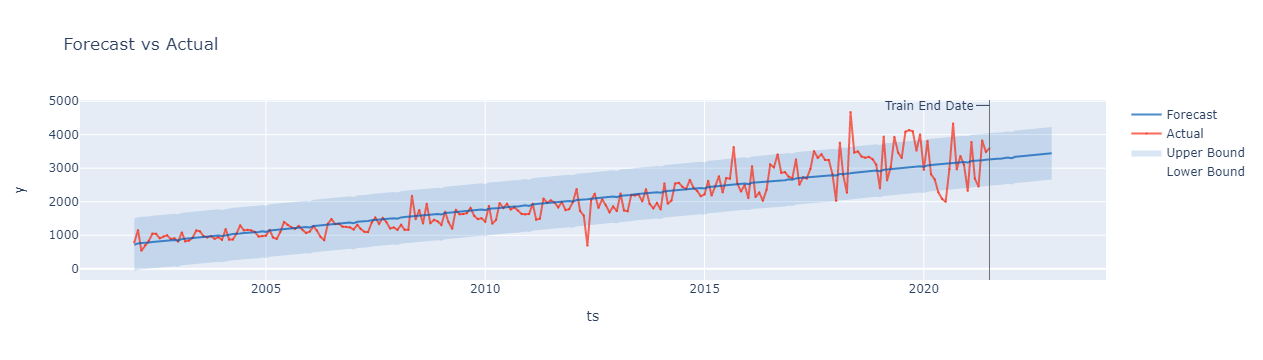

In [15]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [16]:
fig.write_html('gk_iepsc.html')

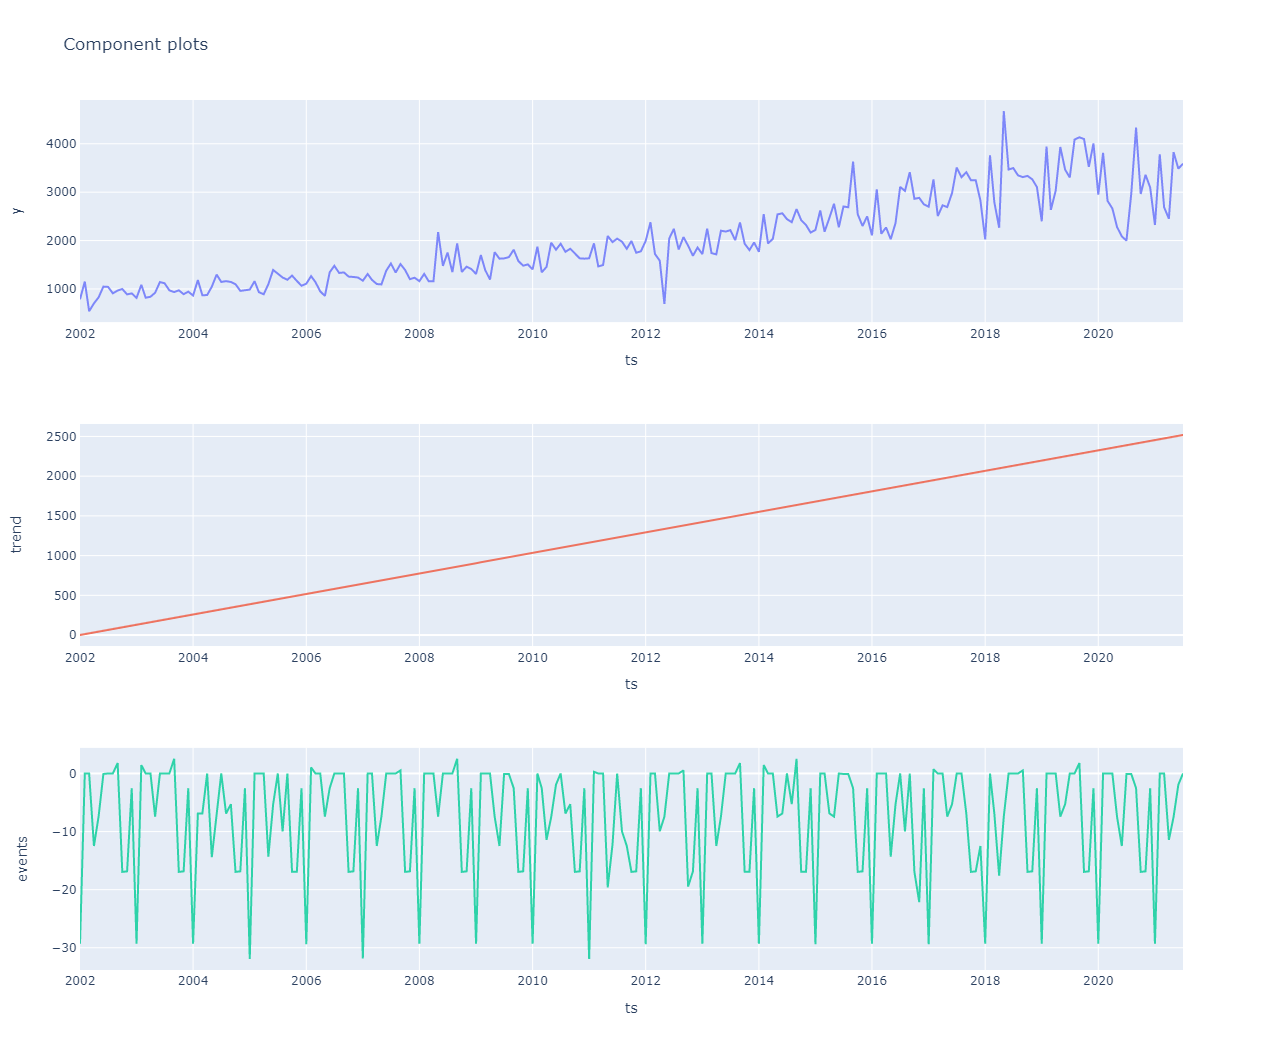

In [17]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [18]:
iepsc_r=forecast.df.forecast

### 3.3 IEPS Tabacos

In [19]:
iepst=df[['fecha','ieps_tabacos']]
iepst=iepst.dropna()
iepst.columns=['ts','y']
iepst.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [20]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepst,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


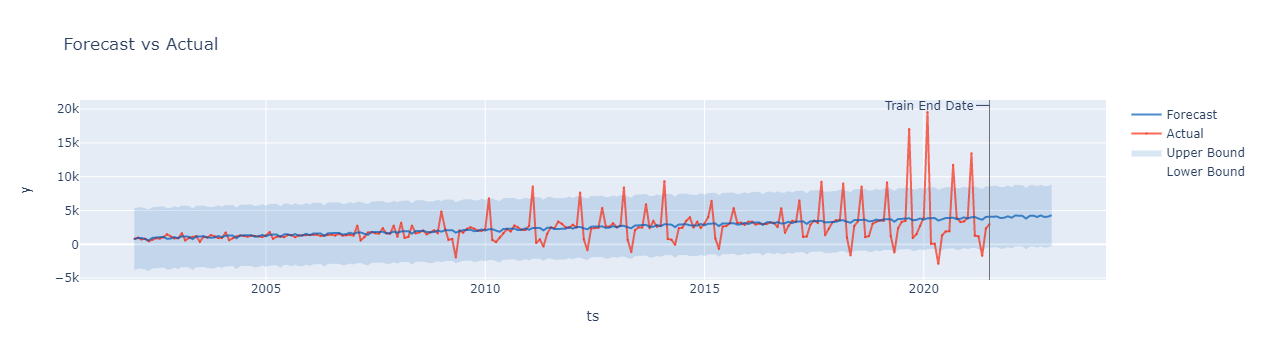

In [21]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [22]:
fig.write_html('gk_iepst.html')

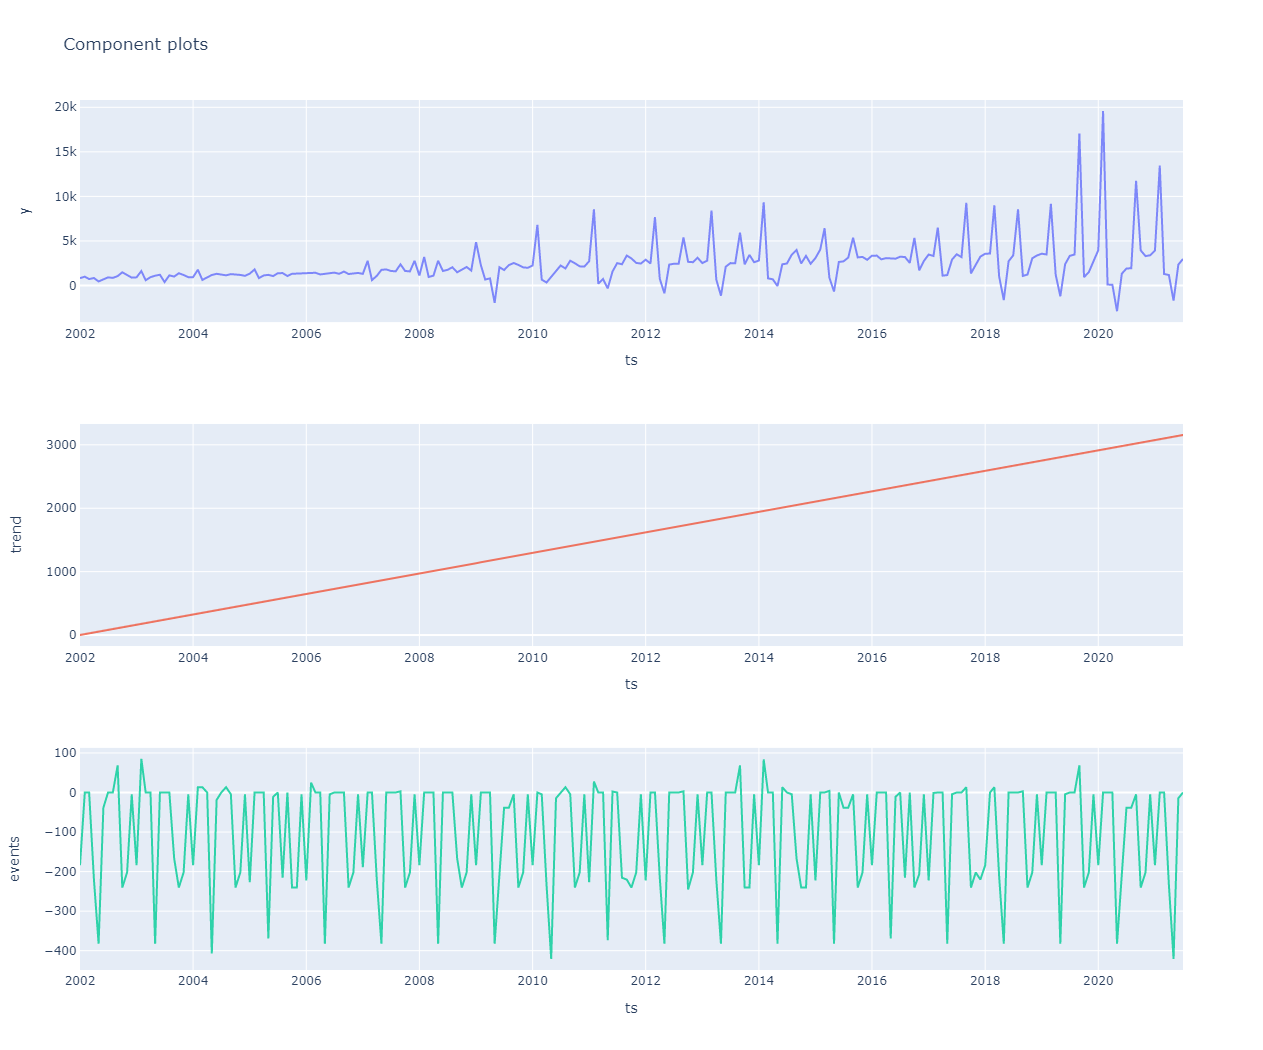

In [23]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [24]:
iepst_r=forecast.df.forecast

### 3.4 IEPS Gasolinas y Diésel

In [25]:
iepsg=df[['fecha','ieps_gas']]
iepsg=iepsg.dropna()
iepsg.columns=['ts','y']
iepsg.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [26]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepsg,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


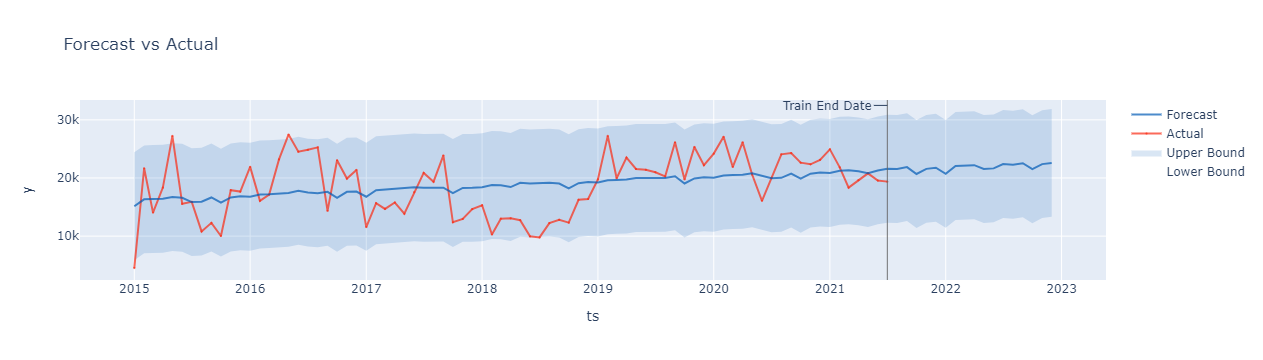

In [27]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [28]:
fig.write_html('gk_iepsg.html')

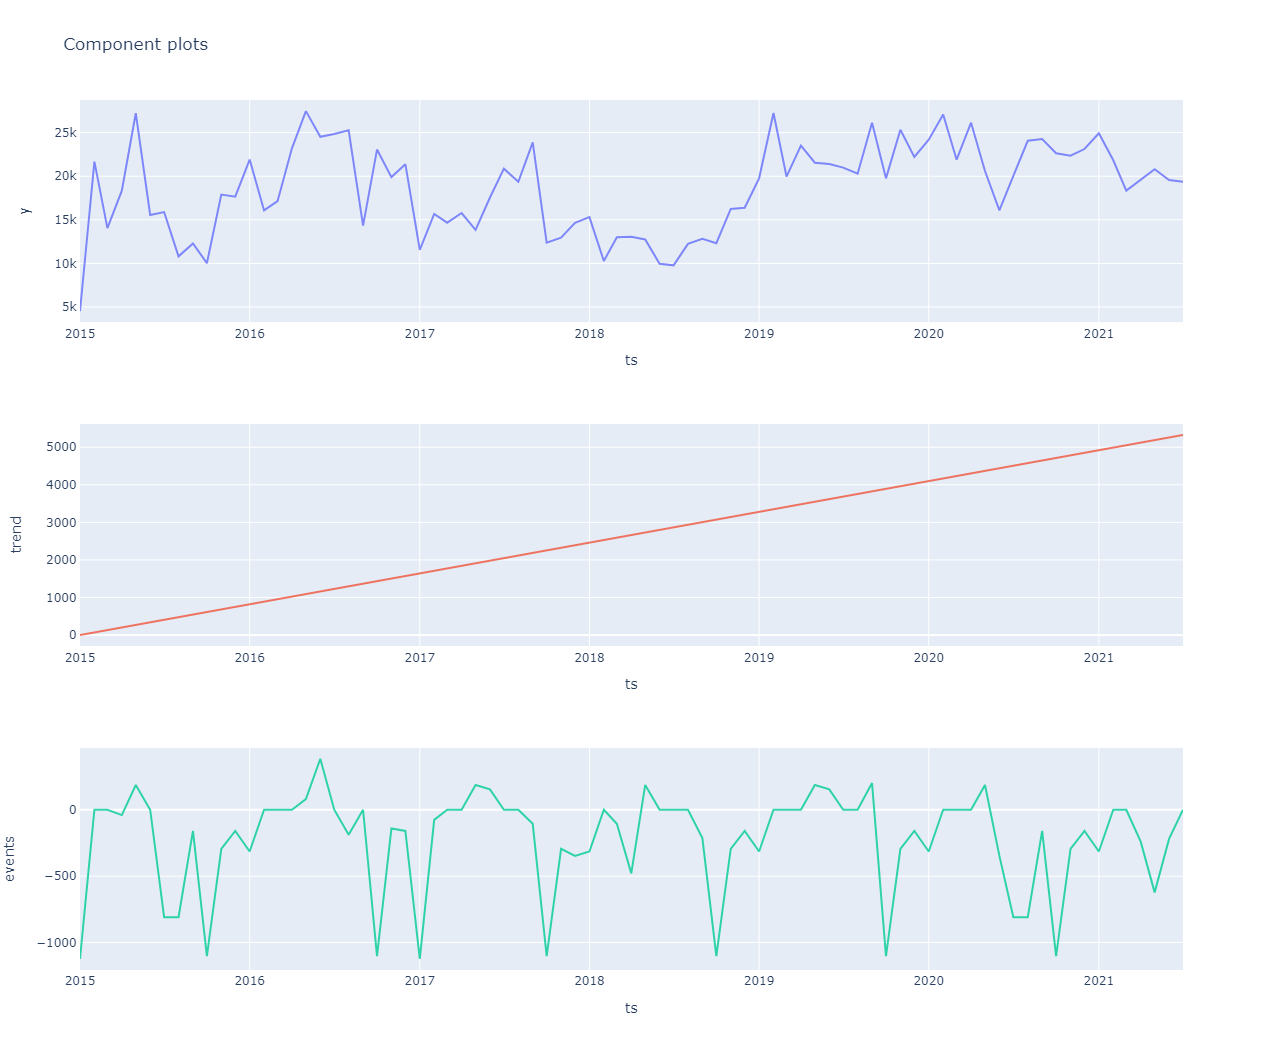

In [29]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [30]:
iepsg_r=forecast.df.forecast

### 3.5 IEPS Bebidas Saborizadas

In [31]:
iepsbs=df[['fecha','ieps_bebidassab']]
iepsbs=iepsbs.dropna()
iepsbs.columns=['ts','y']
iepsbs.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [32]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepsbs,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


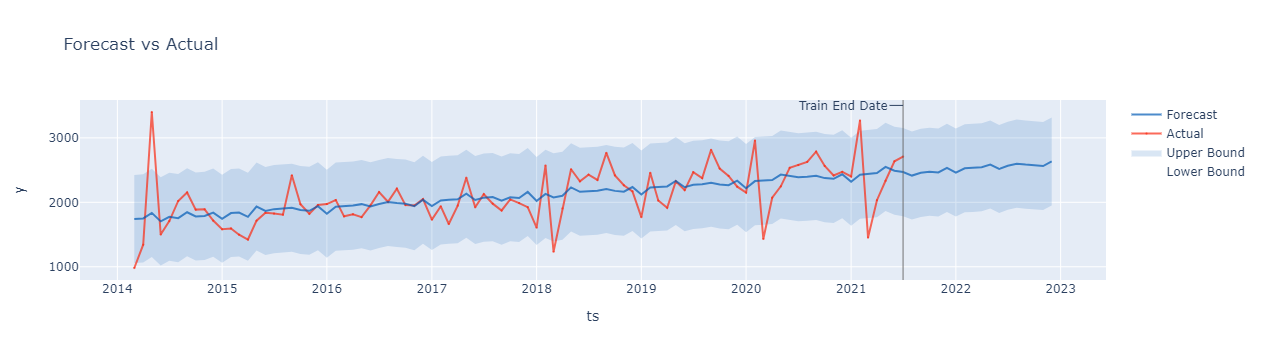

In [33]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [34]:
fig.write_html('gk_iepsbs.html')

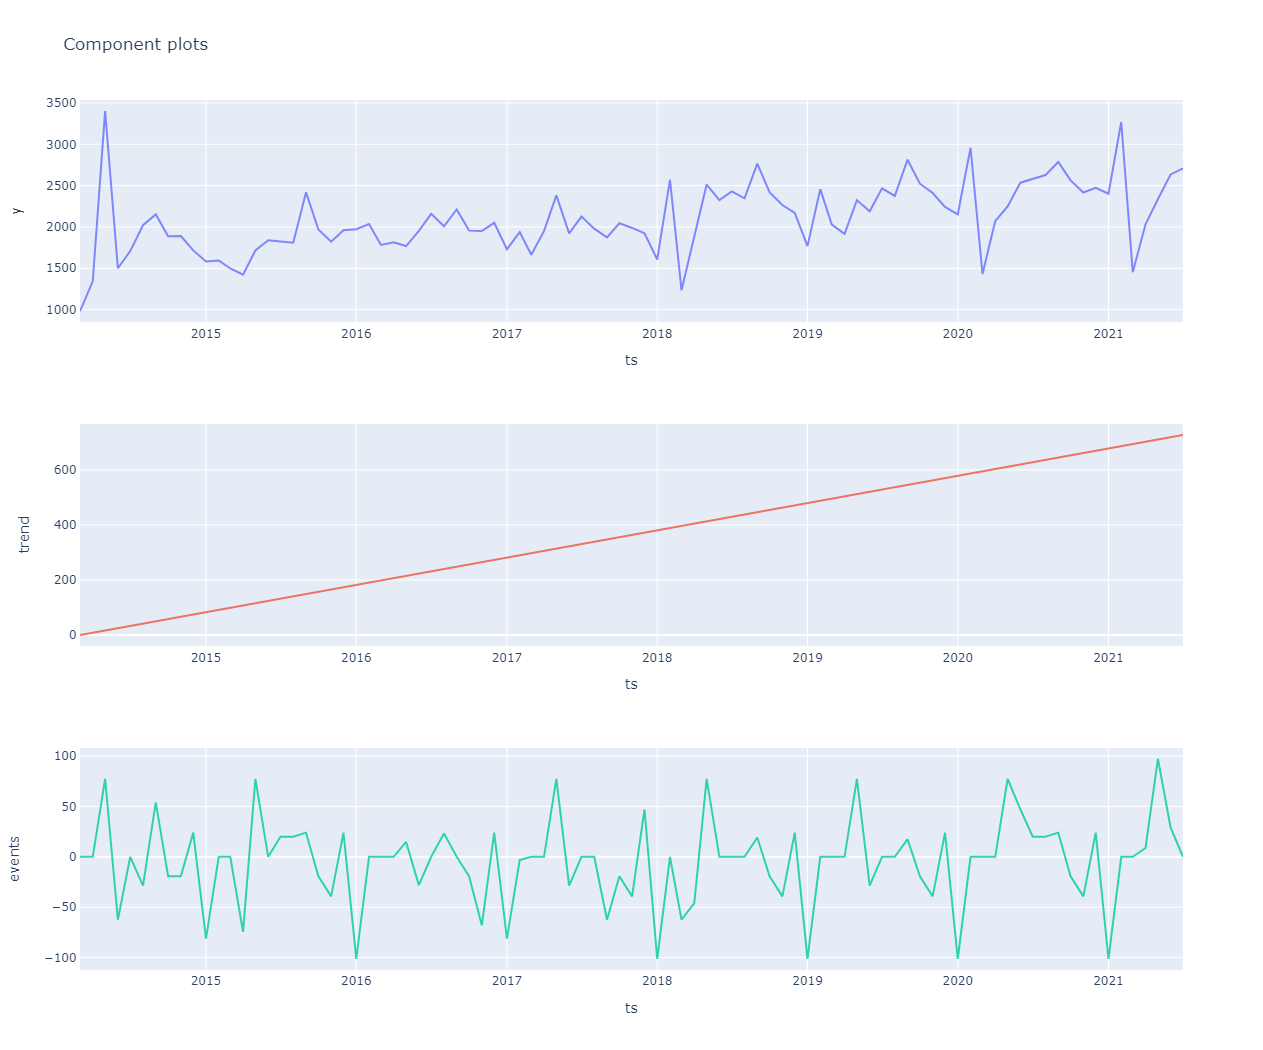

In [35]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [36]:
iepsbs_r=forecast.df.forecast

### 3.6 IEPS Alimentos

In [37]:
iepsa=df[['fecha','ieps_alimentos']]
iepsa=iepsa.dropna()
iepsa.columns=['ts','y']
iepsa.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [38]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iepsa,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


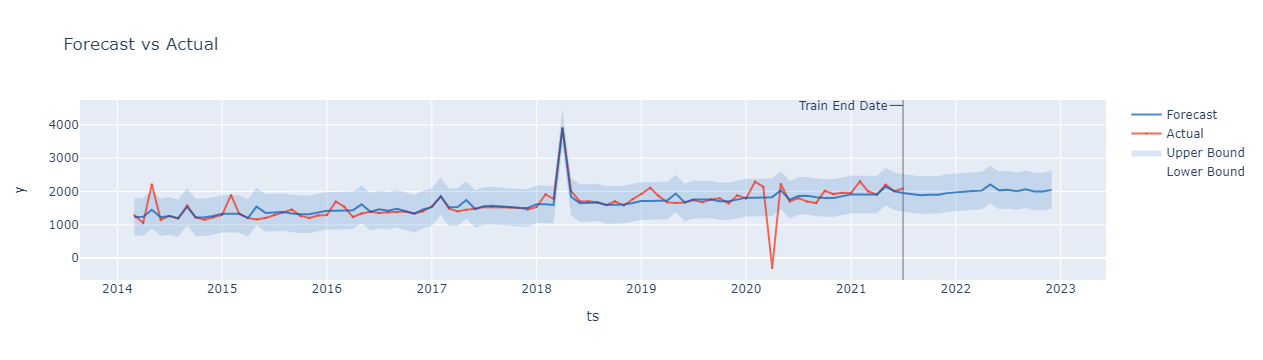

In [39]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [40]:
fig.write_html('gk_iepsa.html')

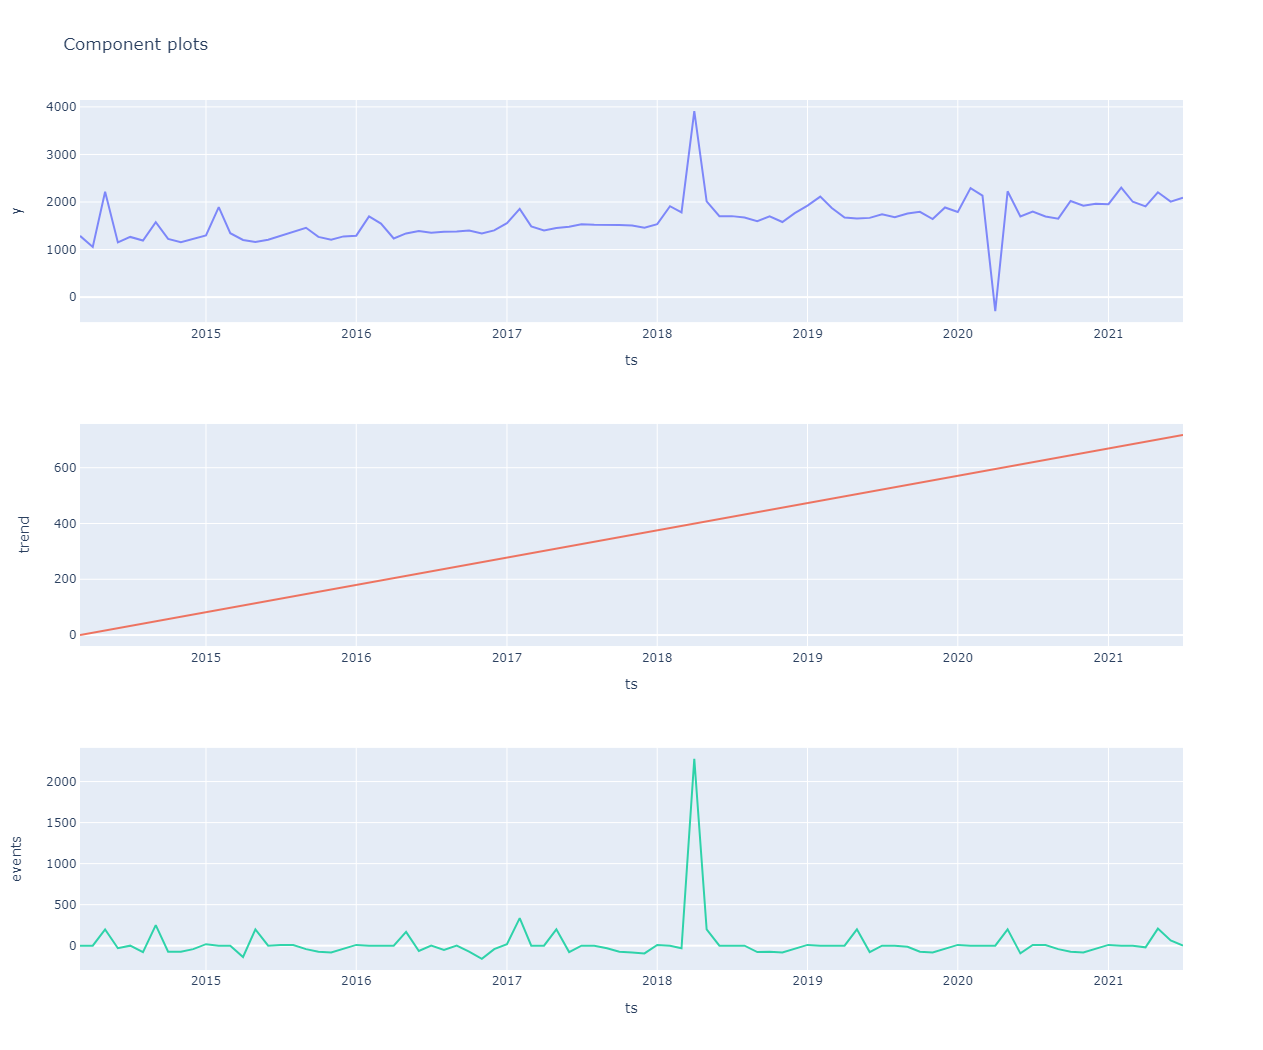

In [41]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [42]:
iepsa_r=forecast.df.forecast

### 3.7 Importacion

In [43]:
importacion=df[['fecha','importacion']]
importacion=importacion.dropna()
importacion.columns=['ts','y']
importacion.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [44]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=importacion,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


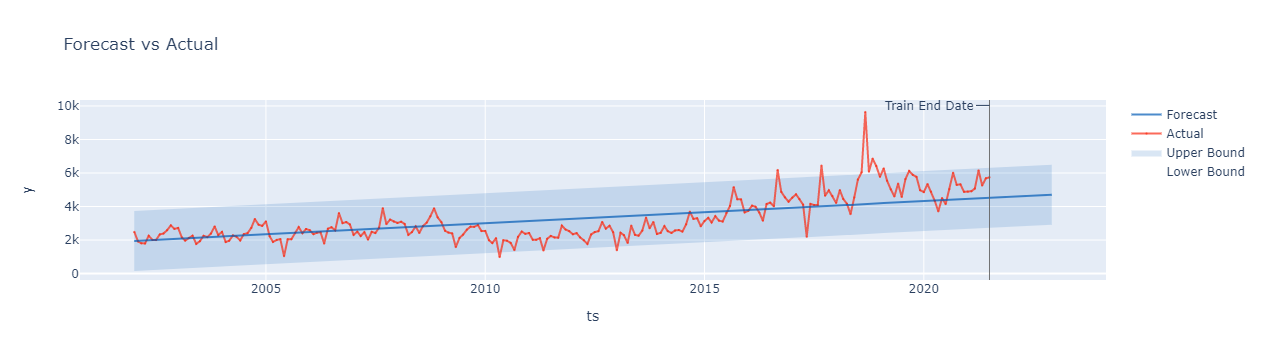

In [45]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [46]:
fig.write_html('gk_importacion.html')

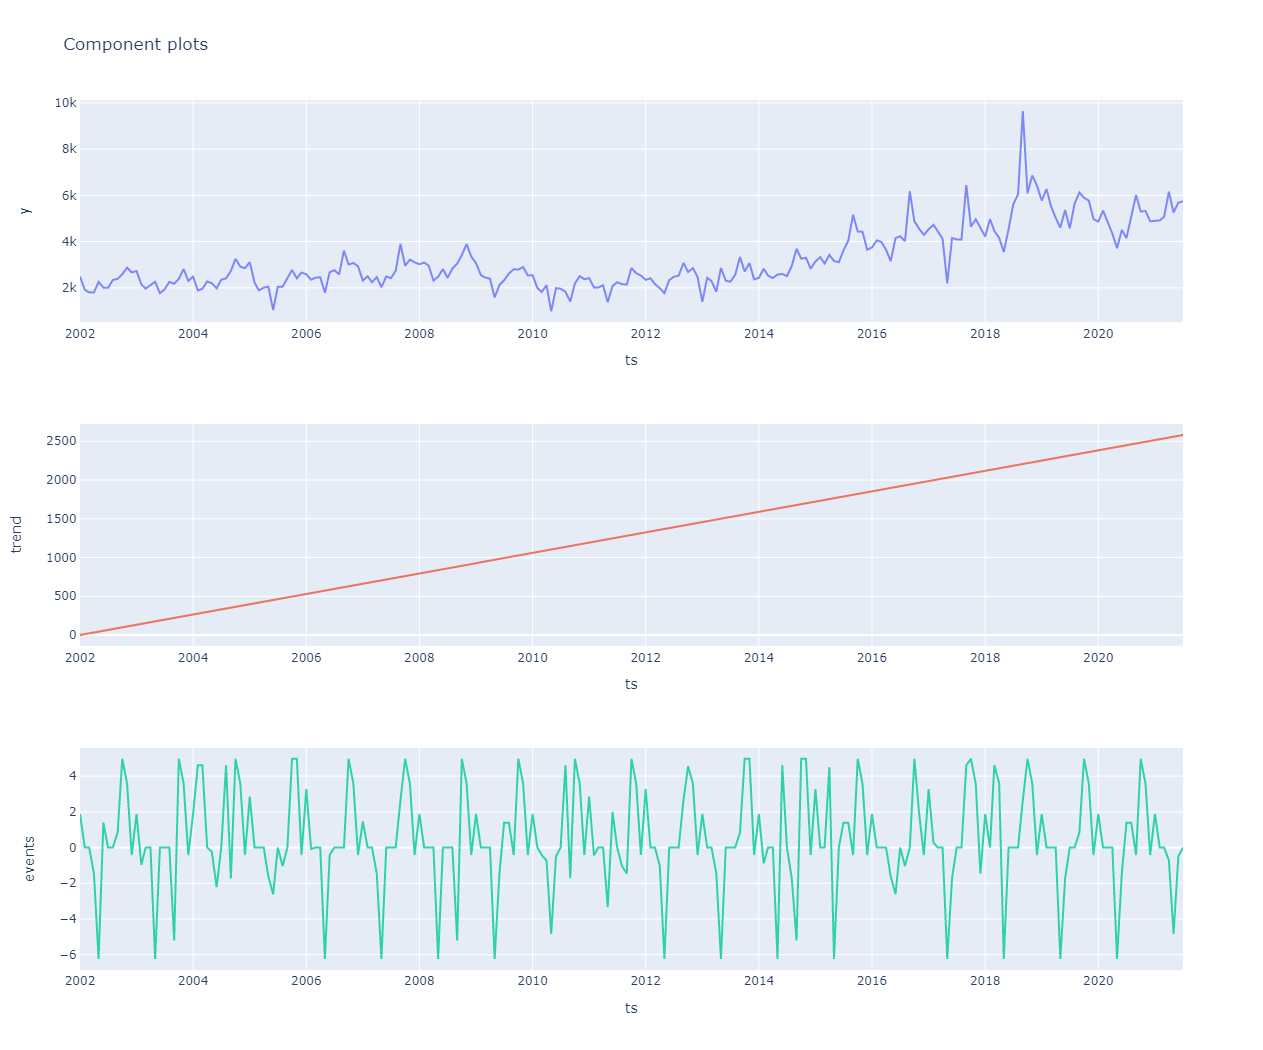

In [47]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [48]:
importacion_r=forecast.df.forecast

### 3.8 Ingresos Petroleros

In [49]:
petr=df[['fecha','rfp_petroleros']]
petr=petr.dropna()
petr.columns=['ts','y']
petr.dtypes

ts    datetime64[ns]
y            float64
dtype: object

In [50]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=petr,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=17,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


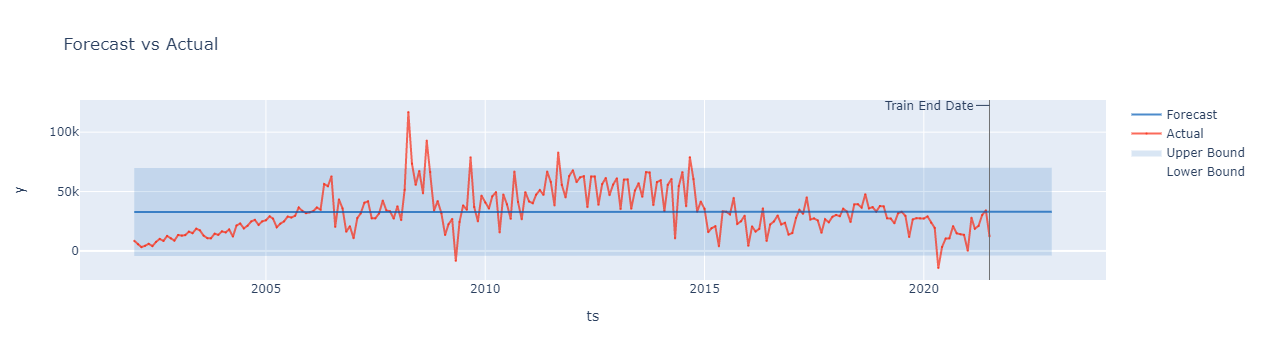

In [51]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [52]:
fig.write_html('gk_petr.html')

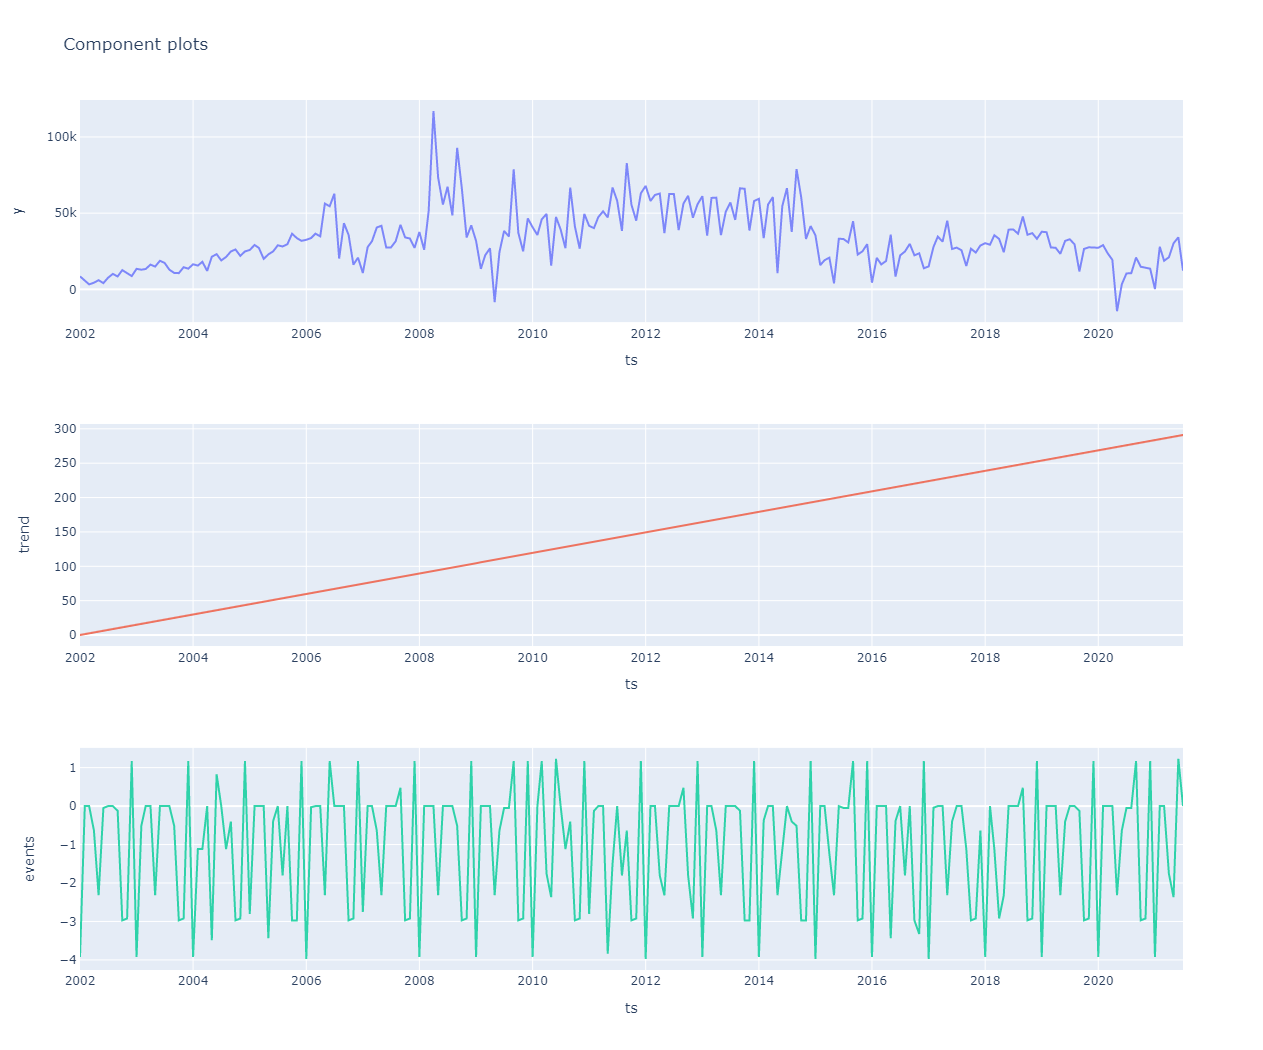

In [53]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [54]:
petr_r=forecast.df.forecast
gk_men=pd.DataFrame({'ieps_gas': iepsg_r,
    'ieps_tabacos': iepst_r,
    'ieps_bebidas': iepsb_r,
    'ieps_cervezas': iepsc_r,
    'ieps_bebidassab': iepsbs_r,
    'ieps_alimentos': iepsa_r,
    'importacion': importacion_r,
    'rfp_petroleros': petr_r
})
gk_men.tail()

ieps_gas  ieps_tabacos  ieps_bebidas  ieps_cervezas  ieps_bebidassab  \
247       NaN   4046.491975   1663.589226    3393.879730              NaN   
248       NaN   4275.808857   1539.732115    3414.806805              NaN   
249       NaN   4048.658191   1382.965740    3408.487465              NaN   
250       NaN   4100.710459   1532.674383    3419.545699              NaN   
251       NaN   4311.450569   1422.371195    3444.485315              NaN   

     ieps_alimentos  importacion  rfp_petroleros  
247             NaN  4664.036116    33062.495614  
248             NaN  4676.316885    33065.569260  
249             NaN  4692.172570    33063.824276  
250             NaN  4702.026381    33065.141289  
251             NaN  4708.912901    33070.461467

In [55]:
gk_men.to_csv('greykite_mensuales')

## 4. Análisis de las Series Trimestrales

Nota. Solo dejaré comentarios para la serie de ISR. Para el IVA dejo el análisis sin comentarios.

### 4.1 Impuesto Sobre la Renta, ISR

Para utilizar Prophet, los datos deben ser cargados con una columna *ds* que tenga las fechas en formato estandar y una variable *y* que incluya la serie a estimar. Los ajustes que incluí al modelo estandar fueron 2:
- Dado que la serie a estimar es trimestral, tengo que indicar que la estacionalidad en multiplicativa.
- Puedo incluir variables explícativas a Prophet, por lo que consideré el PIB y la reforma ISR.
- Alternativamente al punto anterior, puedo indicar el punto de quiebre de manera manual y evitar incluir variables dummy. 
    
El resto del análisis que realiza Prophet es bastante automático y el pronóstico que obtuve me parece muy adecuado:

In [56]:
trim = pd.read_csv('202108trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
trim['fecha']=trim.index
trim.tail()

ano  mes  dia       fechas  pib_real  pib_reale4     IPI  \
fecha                                                                   
2021-10-01  2021   10    1      2021/04  18725631  4681407.77  143.74   
2022-01-01  2022    1    1  2022/01 /r1  18021273  4505318.26  149.32   
2022-04-01  2022    4    1      2022/02  18331787  4582946.70  148.64   
2022-07-01  2022    7    1      2022/03  18308165  4577041.25  149.00   
2022-10-01  2022   10    1      2022/04  19118869  4779717.33  149.63   

            rfp_neta  isr  iva  rfp_real  isr_real  iva_real  tasa iva  \
fecha                                                                    
2021-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-01-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-04-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-07-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   

            reformaisr  covid      fecha  
fecha                                     
2021-10-01           1      0 2021-10-01  
2022-01-01           1      0 2022-01-01  
2022-04-01           1      0 2022-04-01  
2022-07-01           1      0 2022-07-01  
2022-10-01           1      0 2022-10-01

In [57]:
metadata = MetadataParam(
    time_col='ts',
    value_col='y',
    freq='QS',
    date_format='YYYY-MM-DD'
)
custom_model_components = ModelComponentsParam(
    seasonality={
        "yearly_seasonality": "auto",
        "quarterly_seasonality": "auto",
        "monthly_seasonality": "auto",
        "weekly_seasonality": False,
        "daily_seasonality": False
    },
    regressors=dict(
        regressor_cols=["var1", "var2"]
    )
 )

In [58]:
df=trim[['fecha','isr_real','pib_reale4','reformaisr']]
df.columns=['ts','y','var1','var2']
#ts = UnivariateTimeSeries()
#ts.load_data(
#    df=df,
#    time_col="ts",
#    value_col="y",
#    freq="QS")  # optional, but recommended if you have missing data points
#               # W for weekly, D for daily, H for hourly, etc. See ``pd.date_range``
#ts.df?

In [59]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=df,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=6,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


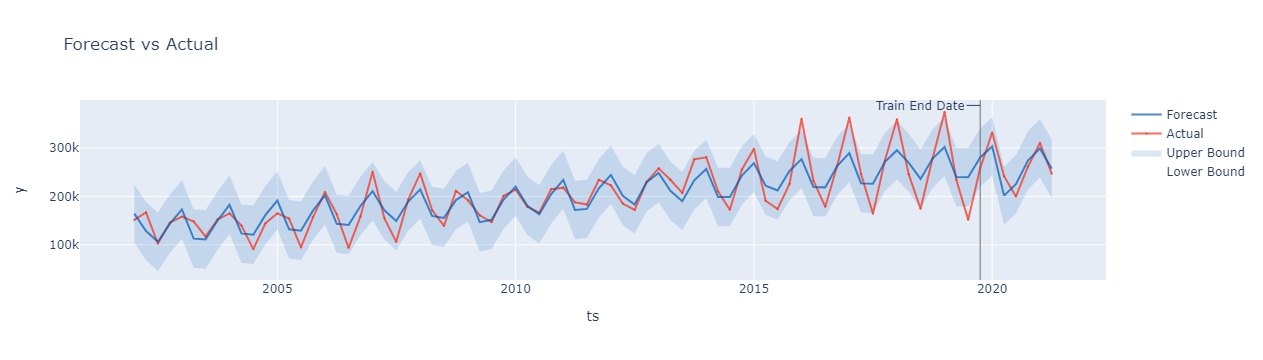

In [60]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

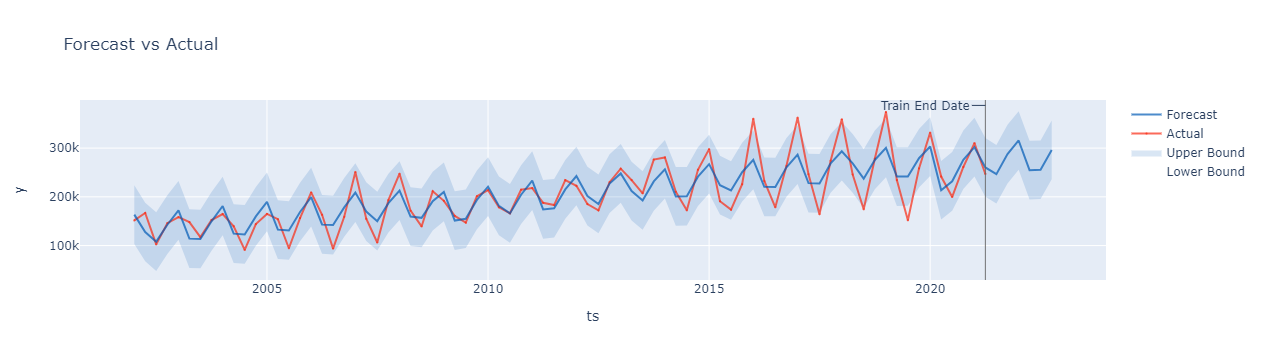

In [61]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [62]:
fig.write_html('gk_isr.html')

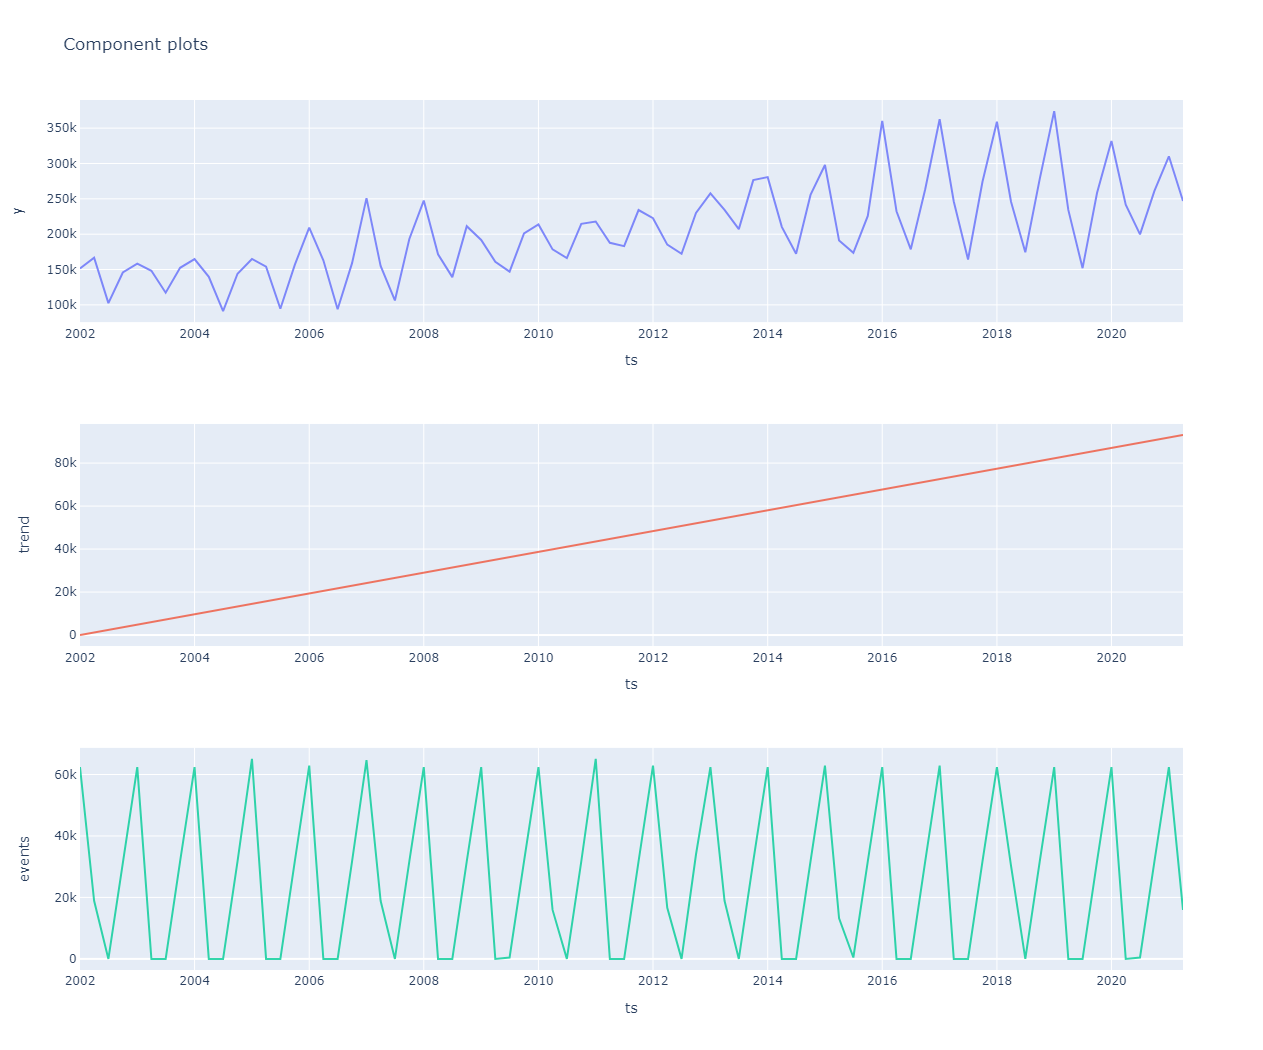

In [63]:
fig = forecast.plot_components()
plotly.io.show(fig)

De hecho, se puede desagregar el pronóstico resultante de Prophet en sus componentes: tendencia, parte estacional y la parte correspondiente a las variables explícativas:

In [64]:
isr_r=forecast.df.forecast
isr_r.tail()

79    287685.842312
80    315622.491314
81    254648.948959
82    255630.734145
83    296249.525337
Name: forecast, dtype: float64

### 4.2 Impuesto al Valor Agregado, IVA

In [65]:
iva=trim[['fecha','iva_real','pib_reale4','tasa iva']]
iva.columns=['ts','y','var1','var2']
iva.tail(8)

ts           y        var1  var2
fecha                                              
2021-01-01 2021-01-01  180536.600  4340383.68    16
2021-04-01 2021-04-01  198732.452  4440839.82    16
2021-07-01 2021-07-01         NaN  4461053.85    16
2021-10-01 2021-10-01         NaN  4681407.77    16
2022-01-01 2022-01-01         NaN  4505318.26    16
2022-04-01 2022-04-01         NaN  4582946.70    16
2022-07-01 2022-07-01         NaN  4577041.25    16
2022-10-01 2022-10-01         NaN  4779717.33    16

In [66]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=iva,  # input data
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        model_components_param=custom_model_components,
        metadata_param=metadata,
        forecast_horizon=6,
        coverage=0.95
    )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


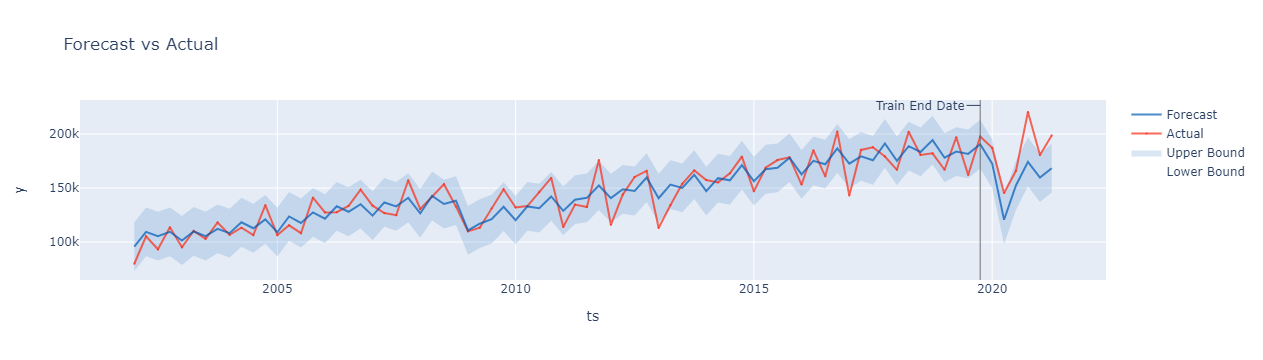

In [67]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

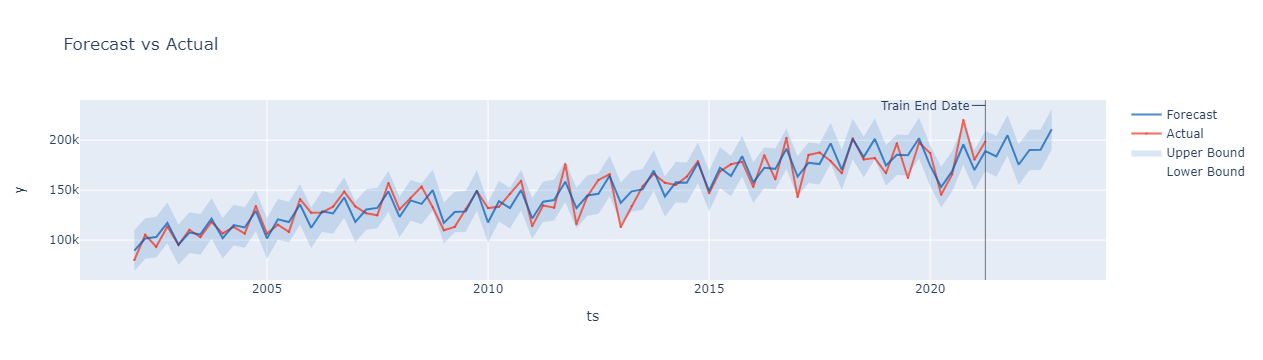

In [68]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [69]:
fig.write_html('gk_iva.html')

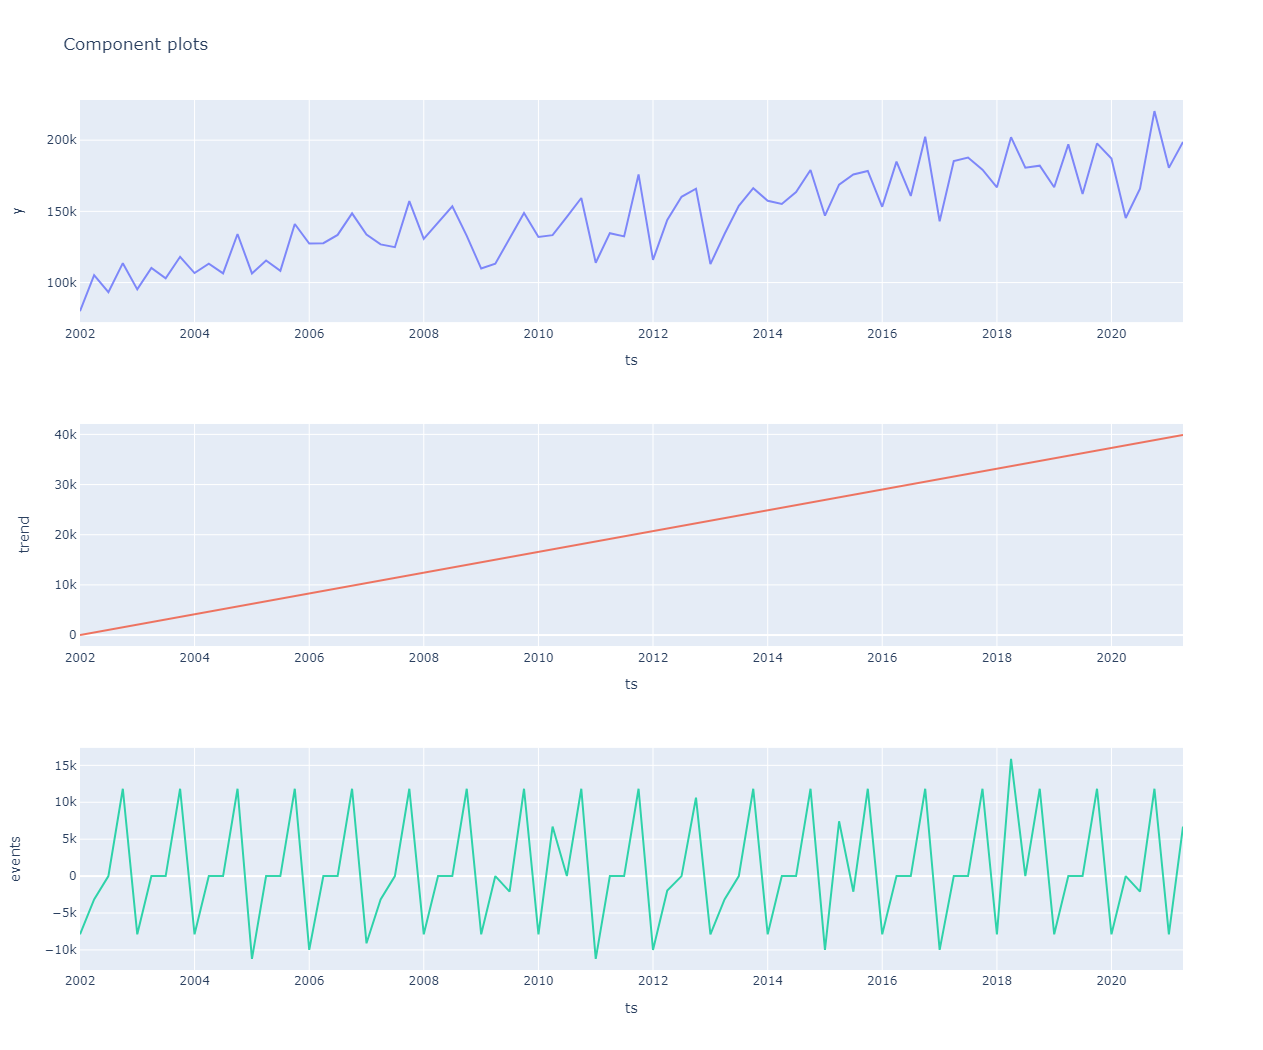

In [70]:
fig = forecast.plot_components()
plotly.io.show(fig)

In [71]:
iva_r=forecast.df.forecast
gk_trim=pd.DataFrame({'isr':isr_r,'iva': iva_r})
gk_trim.tail()

isr            iva
79  287685.842312  204984.468175
80  315622.491314  175456.485697
81  254648.948959  190270.030967
82  255630.734145  190551.781855
83  296249.525337  210969.249174

In [72]:
gk_trim.to_csv('greykite_trimestrales')

## 5. Conclusiones

Para ver las conclusiones sugiero revisar el respectivo blog [aquí](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/)